### Problem statement and overview of notebook
In this notebook, I built a recommender system using product embeddings that I trained from sequences of products viewed by users on an e-commerce website. 

Product recommendation has been an important machine learning application in e-commerce. One useful way to solve a recommendation problem is to use the embedding approach. Embeddings are low-dimensional learned representation of entities that puts similar entities close together in the embedding space. The idea of embeddings has been influential in natural language processing. Word embeddings are trained using some form of text input with the assumption that words occurring in similar contexts tend to have similar meanings. More recently, the embedding approach has been extended to use cases in e-commerce. Sequences of user actions on products are used to train product embeddings based on a similar assumption: products that are viewed/searched in similar 'contexts' tend to have similar characteristics ([by Airbnb](https://medium.com/airbnb-engineering/listing-embeddings-for-similar-listing-recommendations-and-real-time-personalization-in-search-601172f7603e) and [by Drop](https://drop.engineering/building-a-recommender-system-using-embeddings-de5a30e655aa)). 

I used an e-commerce dataset on Kaggle that includes records of customers' viewing of different products at different timestamps. The data was prepared to get sequences of products viewed within a same short session. A training set consisting of all pairs of products that are viewed in sequence was then built. Positive samples of product pairs and negative samples (pairs that were not actually viewed in sequence) were generated for an embedding neural network. The task of the neural network was to predict whether a given product pair was legitimate, i.e., whether the products were viewed in sequence. After training the neural network, its embedding layer was extracted and used for finding similar products.


### Outline of notebook
**1. Loading and preparing data**
<br>**2. Building training data for prediction task to be used in neural network training**
<br>- Create target item, context item pairs
<br>- Generate positive and negative training examples
<br>**3. Building and training embedding neural network**
<br>**4. Extracting embeddings and making recommendations for similar products**
<br>**5. Validating embeddings**
<br>- Comparing within-category and cross-category similarities between items
<br>- Visualizing embeddings using TSNE

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import collections
from datetime import datetime
import random
import itertools
from keras.models import Model
from keras.layers import Embedding, Input, Reshape, Dense
from keras.layers.merge import Dot
from sklearn.manifold import TSNE

Using TensorFlow backend.


In [2]:
pd.set_option('chained_assignment',None)

### Loading and preparing data

#### Get viewing data and datetime columns

In [3]:
df = pd.read_csv('events.csv')

# only use data where event is view
df = df[df['event']=='view'].reset_index(drop=True)\
                            .drop(columns=['event', 'transactionid'])

# change unix timestamp to datetime
def change_unix_timestamp_to_date(unix_timestamp):
    '''converts unix timestampt to a date'''
    result = datetime.utcfromtimestamp(unix_timestamp/1000)
    return result.strftime('%Y-%m-%d %H:%M:%S')

df['timestamp'] = df['timestamp'].apply(change_unix_timestamp_to_date)\
                                 .apply(pd.to_datetime)

# have a column with just date
df['date'] = df['timestamp'].apply(datetime.date)

df.head()

,timestamp,visitorid,itemid,date
0,2015-06-02 05:02:12,257597,355908,2015-06-02
1,2015-06-02 05:50:14,992329,248676,2015-06-02
2,2015-06-02 05:13:19,111016,318965,2015-06-02
3,2015-06-02 05:12:35,483717,253185,2015-06-02
4,2015-06-02 05:02:17,951259,367447,2015-06-02


#### Subset data for views that are during a same session not longer than 30 mins
During an online shopping session, customers often search for and view items that they intend to purchase. They often check out multiple items for comparison before deciding on what to buy. With this idea, I used items that are viewed by a same customer during a short session (not longer than 30 minutes) for subsequent modeling. 

In [4]:
# subset data where each visitor viewed more than one item on a day
df['view_count'] = df.groupby(['visitorid', 'date'])['itemid'].transform('count')
df_sub = df[df['view_count']>1].reset_index(drop=True)

# sort values by timestamp and visitorid
df_sub.sort_values(by=['visitorid', 'timestamp'], inplace=True)

# time elapsed in seconds from a preceding view by each visitor
df_sub['timestamp_lag1'] = df_sub.groupby(['visitorid', 'date'])['timestamp'].shift()
df_sub['time_elapsed'] = (df_sub['timestamp'] - df_sub['timestamp_lag1']).astype('timedelta64[s]')
# cumulative time elasped since beginning of session
df_sub['time_elapsed_cum'] = df_sub.groupby(['visitorid', 'date'])['time_elapsed'].cumsum()

# use data where time since beginning of session is not greater than 1800 seconds (30 mins)
df_sub.fillna({'time_elapsed_cum': 0}, inplace=True)
df_sub = df_sub[df_sub['time_elapsed_cum']<=1800].reset_index(drop=True)

#### Get list of viewed item sequences

In [5]:
df_sub['itemid'] = df_sub['itemid'].astype(str)
df_seq_list = df_sub.groupby(['visitorid', 'date'])['itemid']\
                    .apply(lambda x: ' '.join(x).split(' '))\
                    .reset_index().rename(columns={'itemid': 'itemid_list'})
# sequences that contain at least 5 items
seq_list = [seq for seq in list(df_seq_list['itemid_list']) if len(seq)>4]
seq_list[:3]

[['325215',
  '325215',
  '259884',
  '216305',
  '342816',
  '342816',
  '216305',
  '325215'],
 ['358388', '198762', '429304', '198762', '49967', '279059'],
 ['388096', '283115', '38965', '319680', '283115', '388096']]

A viewing sequence may contain consecutive duplicated items (e.g. ['297886', '297886', '297886'], ['314553', '314553', '100735']). Will only keep one instance of the consecutive duplicates. Non-consecutive duplicates (['314553', '100735', '314553']) won't be changed.

In [6]:
def remove_consecutive_duplicates(a_list):
    '''removes duplicated item views when they occur consecutively'''
    for i in range(len(a_list)-1, 0, -1):
        if a_list[i] == a_list[i-1]:
            del a_list[i]
    return a_list

seq_list= [remove_consecutive_duplicates(seq) for seq in seq_list]
seq_list = [seq for seq in seq_list if len(seq)>4]
seq_list[:3]

[['325215', '259884', '216305', '342816', '216305', '325215'],
 ['358388', '198762', '429304', '198762', '49967', '279059'],
 ['388096', '283115', '38965', '319680', '283115', '388096']]

#### Create item id to int dictionary and int to item id dictionary
Create a mapping of item ids to integers and a reverse mapping of integers to item ids. The integers will be fed into the neural network and the mappings help keep track of item ids. 

In [7]:
# all unique items
items = set([item for seq in seq_list for item in seq])

# create dictionaries of item to int and int to item
item_to_int = {item: i for i, item in enumerate(items)}
int_to_item = {i: item for i, item in enumerate(items)}

### Building training data for prediction task
#### Create target item, context item pairs
When training word2vec models, pairs of target word and context word (word adjacent to target words within a certain context window) can be constructed from sequences of words, i.e., sentences. Similarly, from each sequence of viewed items, I created pairs of target item and context item, items that are viewed before or after the target item within a sepecified window. For example, with the item id sequence ['325215', '259884', '216305', '342816', '216305', '325215'] and a window size of 2, 3 target-context item pairs can be created for '259884': ['259884', '325215'], ['259884', '216305'], and ['259884', '342816'].

In [8]:
# get list of target item, context item pairs
WINDOW_SIZE = 2

item_pairs = []
for seq in seq_list:
    for idx, item in enumerate(seq):
        # get each of context items within the window
        for context_item in seq[max(idx-WINDOW_SIZE, 0):min(idx+WINDOW_SIZE, len(seq))+1]: 
            if context_item != item:
                item_pairs.append([item, context_item])

item_pairs[:5]

[['325215', '259884'],
 ['325215', '216305'],
 ['259884', '325215'],
 ['259884', '216305'],
 ['259884', '342816']]

In [9]:
# get integers corresponding to each target item, context item pair
item_idx_pairs = [(item_to_int[pair[0]], item_to_int[pair[1]]) for pair in item_pairs]

# get unique target item index, context item index pairs
item_idx_pairs_set = set(item_idx_pairs)

item_idx_pairs[:5]

[(14231, 54389),
 (14231, 37938),
 (54389, 14231),
 (54389, 37938),
 (54389, 46832)]

#### Generator for training samples
From the last section, I've got positive samples of target, context items, item pairs that are viewed in sequence. Negative samples, pairs that are not viewed in sequence, are needed for the neural network to do the prediction task. In the following code, a generator creates batches of samples each time it is called. For positive samples, it randomly selects pairs from all target, context item pairs (item_idx_pairs) and assigns them a label of 1. For negative samples, it randomly generates target item and context item and if they are not in the target, context item pairs, assigns them a label of 0. Using a generator works well for incremental training of neural network (training on batches) and frees up memory without having to store all training data in memory. 

In [10]:
random.seed(100)

def generate_batch(item_idx_pairs, n_positive = 50, negative_ratio = 1.0):
    '''Generate batches of samples for training. 
       Randomly selects positive samples from pairs and randomly creates negative samples.
    '''
    
    # Create empty array to hold batch
    batch_size = n_positive * (1 + negative_ratio)
    batch = np.zeros((batch_size, 3))
    
    # labesl for positive and negative examples
    POS_LABEL, NEG_LABEL = 1, 0
        
    # Continue to yield samples
    while True:
        # Randomly choose positive examples
        for idx, (target_id, context_id) in enumerate(random.sample(item_idx_pairs, n_positive)):
            batch[idx, :] = (target_id, context_id, POS_LABEL)
        idx += 1
        
        # Randomly select negative examples until reach batch size
        while idx < batch_size:
            random_target = random.randrange(len(items))
            random_context = random.randrange(len(items))
            
            # Add to batch if random examples not in target, context item pairs
            if random_target != random_context\
            and (random_target, random_context) not in item_idx_pairs_set:
                batch[idx, :] = (random_target, random_context, NEG_LABEL)
                idx += 1
                
        np.random.shuffle(batch)
        yield {'target': batch[:, 0], 'context': batch[:, 1]}, batch[:, 2]

In [11]:
# have a look at a few training examples
X, y = next(generate_batch(item_idx_pairs, n_positive=2, negative_ratio=2))
for target_idx, context_idx, label, in zip(X['target'], X['context'], y):
    print('Target item id: {}; Context item id: {}; Label: {}'.format(int_to_item[target_idx],
                                                                      int_to_item[context_idx],
                                                                      label))

Target item id: 15466; Context item id: 320291; Label: 0.0
Target item id: 381057; Context item id: 196863; Label: 1.0
Target item id: 90230; Context item id: 442131; Label: 1.0
Target item id: 294395; Context item id: 230653; Label: 0.0
Target item id: 81338; Context item id: 346025; Label: 0.0
Target item id: 342222; Context item id: 222369; Label: 0.0


### Building and training model
Now with the training examples ready, it's time to build an embedding neural network. Given a training example pair of target item and context item, the model's task is to predict whether or not the context item is viewed before or after the target item. The model consists of the following layers:
1. Input: parallel inputs for the target item and context item;
2. Embeddings: parallel embeddings for the target item and context item;
3. Dots: computes dot product between the embeddings (make network learn embeddings of target items such that target items with similar context items would have similar embeddings);
4. Reshape: changes shape of dot product
5. Dense: layer with sigmoid activation to generate classification output

During training, the neural network will adjust the embeddings to reduce loss. The resulting embeddings will later be extracted.

In [12]:
def item_embedding_model(embedding_size=50):
    ITEM_COUNT = len(items)
    
    # target item and context item as input
    target = Input(name='target', shape=(1,))
    context = Input(name='context', shape=(1,))
    
    # embed target items and context items
    target_embedding = Embedding(name='target_embedding', 
                                 input_dim=ITEM_COUNT, 
                                 output_dim=embedding_size)(target)
    context_embedding = Embedding(name='context_embedding', 
                                  input_dim=ITEM_COUNT, 
                                  output_dim=embedding_size)(context)
    # merge the layers with dot product along second axis
    dot = Dot(name='dot_product', normalize=True,
              axes=2)([target_embedding, context_embedding])
    
    # reshape to a single number
    merged = Reshape((1,))(dot)

    # squash output for classification
    output = Dense(1, activation='sigmoid')(merged)
    
    model = Model(inputs=[target, context], outputs=output)
    model.compile(optimizer='Adam', loss='binary_crossentropy', 
                  metrics=['accuracy'])
    
    return model

model = item_embedding_model()
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
target (InputLayer)             (None, 1)            0                                            
__________________________________________________________________________________________________
context (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
target_embedding (Embedding)    (None, 1, 50)        2737150     target[0][0]                     
__________________________________________________________________________________________________
context_embedding (Embedding)   (None, 1, 50)        2737150     context[0][0]                    
____________________

In [13]:
n_positive = 1000

gen = generate_batch(item_idx_pairs, n_positive, negative_ratio=4)

# Train the model
h = model.fit_generator(gen, epochs=15, 
                        steps_per_epoch=len(item_idx_pairs)//n_positive,
                        verbose=2)

Instructions for updating:
Use tf.cast instead.
Epoch 1/15
 - 102s - loss: 0.6336 - accuracy: 0.7182
Epoch 2/15
 - 94s - loss: 0.5682 - accuracy: 0.7434
Epoch 3/15
 - 97s - loss: 0.5277 - accuracy: 0.7677
Epoch 4/15
 - 93s - loss: 0.5026 - accuracy: 0.7810
Epoch 5/15
 - 93s - loss: 0.4986 - accuracy: 0.7827
Epoch 6/15
 - 94s - loss: 0.5030 - accuracy: 0.7811
Epoch 7/15
 - 97s - loss: 0.4976 - accuracy: 0.7838
Epoch 8/15
 - 99s - loss: 0.4844 - accuracy: 0.8019
Epoch 9/15
 - 100s - loss: 0.4664 - accuracy: 0.8154
Epoch 10/15
 - 98s - loss: 0.4769 - accuracy: 0.8069
Epoch 11/15
 - 97s - loss: 0.4789 - accuracy: 0.8035
Epoch 12/15
 - 95s - loss: 0.4806 - accuracy: 0.8032
Epoch 13/15
 - 96s - loss: 0.4766 - accuracy: 0.8047
Epoch 14/15
 - 96s - loss: 0.4829 - accuracy: 0.8004
Epoch 15/15
 - 96s - loss: 0.4744 - accuracy: 0.8079


Loss decreases and accuracy increases as training progresses. The model should have learned something about the item representation.

### Extracting item embeddings from model for recommendation

In [14]:
# extract target item embedding
target_items = model.get_layer('target_embedding')
item_weights = target_items.get_weights()[0]

# normalize weights so that cosine similarity can later be calculated as dot product of two weights
item_lengths = np.linalg.norm(item_weights, axis=1)
normalized_items = (item_weights.T / item_lengths).T

####  Find similar products to input item

In [15]:
def find_similar_items(item, n):
    '''finds n items most similar to an input item for recommendation'''
    # make sure inputted item is in item_to_int dict
    try:
        # calculate cosine similarity between inputted item and all other items
        similarities = np.dot(normalized_items, normalized_items[item_to_int[item]])
        similar_idx = np.argsort(similarities)[-(n+1):] 
        print('Items most similar to {}:'.format(item))
        for idx in reversed(similar_idx[:n]): # exclude input item itself
            print('Item: {}, similarity: {:.2f}'.format(list(items)[idx], similarities[idx]))
    except KeyError:
        print('Item {} not found'.format(item))

find_similar_items('325215', 10)

Items most similar to 325215:
Item: 342816, similarity: 0.72
Item: 441734, similarity: 0.72
Item: 29940, similarity: 0.70
Item: 154034, similarity: 0.70
Item: 216305, similarity: 0.68
Item: 342264, similarity: 0.65
Item: 54698, similarity: 0.65
Item: 259884, similarity: 0.65
Item: 119107, similarity: 0.64
Item: 140853, similarity: 0.63


### Validating learned embeddings
Although a separte dataset of item properties is also provided, the dataset doesn't include much item information (eg, item name or description) that can be used to validate the learned embeddings. One piece of information that is useful though is item category. The following two methods are used to validate the embeddings.
1. First, for each item, I calculate its mean cosine similarity with other items in the same category as well as its mean similarity with items in other categories. The mean within-category similarity and cross-category similarity are then compared. 
2. As a second way of validation, I use T-SNE to reduce the learned 50-d embeddings to 2-d representation. The item weights are then plotted as a function of category to check for patterns.  

Get item categories to be used for validation

In [16]:
df_items1 = pd.read_csv('item_properties_part1.csv')
df_items2 = pd.read_csv('item_properties_part2.csv')
df_items = pd.concat([df_items1, df_items2])

# only use rows with category ids
df_items = df_items[df_items['property']=='categoryid'].reset_index(drop=True)
df_items['itemid'] = df_items['itemid'].astype(str)

# change unix timestamp to datetime
df_items['timestamp'] = df_items['timestamp'].apply(change_unix_timestamp_to_date)\
                                             .apply(pd.to_datetime)

Each item could belong to different categories at different time points. To simplify things, get the most recent category id of each item.

In [17]:
df_cat_id = df_items.sort_values(by=['itemid','timestamp'])\
                    .drop_duplicates(subset='itemid', keep='last')\
                    .reset_index(drop=True)\
                    .drop(columns=['timestamp', 'property'])\
                    .rename(columns={'value': 'cat_id'})

# get integer corresponding to each itemid used in model training
df_cat_id['item_int'] = df_cat_id['itemid'].map(item_to_int)\
                                           .fillna(500000).astype('int32')
df_cat_id = df_cat_id[df_cat_id['item_int']!=500000].reset_index(drop=True)

# only focus on categories with at least 400 items
df_cat_id['item_count'] = df_cat_id.groupby('cat_id')['itemid']\
                                   .transform('count')
df_cat_id_sub = df_cat_id[df_cat_id['item_count']>=400].reset_index(drop=True)

In [18]:
# make a df with the embeddings - 50 weights for each item
dim_cols = ['dim_'+str(i) for i in range(normalized_items.shape[1])]
df_normalized_items = pd.DataFrame(normalized_items, columns=dim_cols)\
                        .reset_index()\
                        .rename(columns={'index': 'item_int'})

# merge df with cat_id and embeddings df
df_embeddings = df_cat_id_sub.merge(df_normalized_items, on='item_int', how='left')
df_embeddings.head()

,itemid,cat_id,item_int,item_count,dim_0,dim_1,dim_2,dim_3,dim_4,dim_5,...,dim_40,dim_41,dim_42,dim_43,dim_44,dim_45,dim_46,dim_47,dim_48,dim_49
0,100095,1051,33651,987,-0.174707,0.058066,0.001521,-0.185954,0.164211,-0.104352,...,-0.071719,-0.007381,-0.033025,0.014009,-0.014108,0.152166,0.074331,0.011806,0.162075,-0.051017
1,100141,1421,6516,541,-0.202868,-0.106598,0.112864,-0.015349,-0.015077,-0.110328,...,0.013397,0.078941,-0.043164,-0.131795,0.081825,-0.030221,-0.211004,0.186938,0.040187,-0.160697
2,100150,1051,37912,987,-0.125141,-0.110968,-0.082635,-0.232531,0.138539,-0.091802,...,-0.055726,-0.022984,-0.017844,0.090339,-0.066840,0.014787,0.088676,0.300389,0.174645,0.028222
3,100199,342,26125,1199,-0.265395,0.227207,-0.310052,-0.286234,-0.034048,-0.126748,...,-0.028335,-0.085957,-0.003140,-0.188810,-0.070151,0.168226,0.156397,0.011868,0.024817,-0.024442
4,100263,769,25321,1177,0.000050,0.077586,0.008592,-0.072405,0.070507,-0.013520,...,-0.234566,0.181371,-0.260122,0.139344,-0.091457,0.174756,0.150392,-0.157728,0.147082,-0.102772


#### Comparison between within-category similarity and cross-category similarity

In [19]:
def similarity_comparison(row):
    '''compute for each item, mean cosine similarity between it and other items
       in the same category and mean cosine similarity between it and items in
       other categories
    '''
    df_same_cat = df_embeddings[(df_embeddings['cat_id']==row['cat_id'])
                                &(df_embeddings['itemid']!=row['itemid'])]
    df_diff_cat = df_embeddings[df_embeddings['cat_id']!=row['cat_id']]
    
    sim_same_cat = np.mean(np.dot(df_same_cat[dim_cols].values, row[dim_cols].values.T))
    sim_diff_cat = np.mean(np.dot(df_diff_cat[dim_cols].values, row[dim_cols].values.T))
    
    return sim_same_cat, sim_diff_cat

df_embeddings['sim_same_cat'], df_embeddings['sim_diff_cat']\
    = zip(*df_embeddings.apply(similarity_comparison, axis=1))

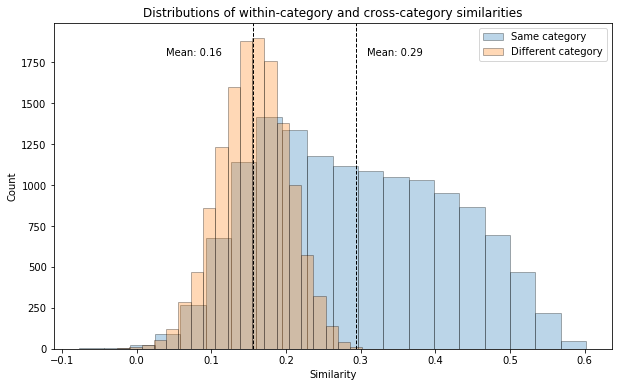

In [29]:
# plot distributions of within-category and cross-category similarities
fig, ax = plt.subplots(figsize=(10, 6))
hist_kws = {'histtype': 'bar', 'edgecolor': 'black', 'alpha': 0.3}

sns.distplot(df_embeddings['sim_same_cat'], label='Same category', 
             ax=ax, bins=20, hist_kws=hist_kws, kde=False)
sns.distplot(df_embeddings['sim_diff_cat'], label='Different category', 
             ax=ax, bins=20, hist_kws=hist_kws, kde=False)

# get and plot mean similarity for within-cat items and cross-cat items
mean_sim_same_cat = df_embeddings['sim_same_cat'].mean()
mean_sim_diff_cat = df_embeddings['sim_diff_cat'].mean()

# plot mean similarities
ax.axvline(mean_sim_same_cat, color='k', linestyle='dashed', linewidth=1)
ax.axvline(mean_sim_diff_cat, color='k', linestyle='dashed', linewidth=1)

# annotation
min_ylim, max_ylim = plt.ylim()
ax.text(mean_sim_same_cat*1.05, max_ylim*0.9, 'Mean: {:.2f}'.format(mean_sim_same_cat))
ax.text(mean_sim_diff_cat*0.25, max_ylim*0.9, 'Mean: {:.2f}'.format(mean_sim_diff_cat))

ax.set_title('Distributions of within-category and cross-category similarities')
ax.set_xlabel('Similarity')
ax.set_ylabel('Count')
ax.legend()
plt.show()

As shown in the plot, mean cosine similarity between items in a same category tend to be higher than similarity beween items in different categories. This is expected to some extent - items within the same categories should share more characteristics than items in different categories in general. So the embeddings do seem to reflect some similarities between items!

#### T-SNE visualization of item embeddings

In [31]:
# run T-SNE to reduce 50d embeddings to 2d representations
tsne = TSNE(n_components=2, random_state=0)
tsne_results = tsne.fit_transform(df_embeddings[dim_cols].values)

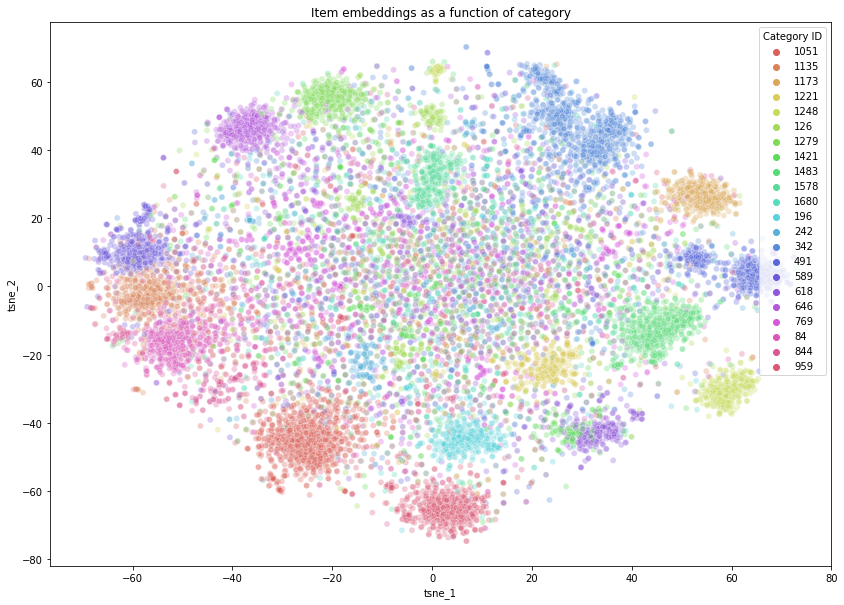

In [39]:
# plot embeddings as a function of category
df_embeddings['tsne_1'] = tsne_results[:, 0]
df_embeddings['tsne_2'] = tsne_results[:, 1]

# get number of unique cat_id
cat_count = df_embeddings['cat_id'].nunique()

fig, ax = plt.subplots(figsize=(14, 10))
sns.scatterplot(x='tsne_1', y='tsne_2', hue='cat_id',
                data=df_embeddings, legend='brief',
                palette=sns.color_palette("hls", cat_count),
                alpha=0.3, ax=ax)
ax.set_title('Item embeddings as a function of category')

# change legend title
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=labels[1:], title="Category ID")

plt.show()

Interestingly, quite a number of items within a same category cluster nicely together, suggesting again that the item embeddings do capture some similarities between items. However, some other items are close toghether with items from other categories. It is possible that some items similar to other are in different categories but are used for a same function/purpose. For example, hiking shoes and camping tents are in different categories but are both items people would use and therefore shop for in prepartion for camping. 

### References
[Book recommendation system](https://github.com/WillKoehrsen/wikipedia-data-science/blob/master/notebooks/Book%20Recommendation%20System.ipynb)
<br>[Move recommedation system from Deep Learning Cookbook](https://github.com/DOsinga/deep_learning_cookbook/blob/master/04.2%20Build%20a%20recommender%20system%20based%20on%20outgoing%20Wikipedia%20links.ipynb)